## Data

In [1]:
# import from google drive
# run this code piece, enter the autorization code
# For mount instructions: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd

from google.colab import drive
drive.mount("/content/drive")

# or import from environment
PROJECT_DIR = "/content/drive/My Drive/Deep Learning System/project"

Mounted at /content/drive


In [2]:
%cd $PROJECT_DIR
# !git clone https://github.com/tuanpham96/bnn-cf-vs-robust "$PROJECT_DIR/bnn-cf-vs-robust"

# !conda config --add channels conda-forge  
# !conda create --name environment_name --file requirements.txt  
# !conda activate environment_name  
# !pip install pytorch==1.1.0 torchvision==0.3.0

/content/drive/My Drive/Deep Learning System/project


In [3]:
!unzip "/content/drive/My Drive/Deep Learning System/project/results.zip" -d "/content"

Archive:  /content/drive/My Drive/Deep Learning System/project/results.zip
  inflating: /content/bnn-cf-vs-robust/.git/HEAD  
  inflating: /content/bnn-cf-vs-robust/.git/config  
  inflating: /content/bnn-cf-vs-robust/.git/description  
  inflating: /content/bnn-cf-vs-robust/.git/hooks/applypatch-msg.sample  
  inflating: /content/bnn-cf-vs-robust/.git/hooks/commit-msg.sample  
  inflating: /content/bnn-cf-vs-robust/.git/hooks/fsmonitor-watchman.sample  
  inflating: /content/bnn-cf-vs-robust/.git/hooks/post-update.sample  
  inflating: /content/bnn-cf-vs-robust/.git/hooks/pre-applypatch.sample  
  inflating: /content/bnn-cf-vs-robust/.git/hooks/pre-commit.sample  
  inflating: /content/bnn-cf-vs-robust/.git/hooks/pre-push.sample  
  inflating: /content/bnn-cf-vs-robust/.git/hooks/pre-rebase.sample  
  inflating: /content/bnn-cf-vs-robust/.git/hooks/pre-receive.sample  
  inflating: /content/bnn-cf-vs-robust/.git/hooks/prepare-commit-msg.sample  
  inflating: /content/bnn-cf-vs-robust/

## Model

Reference: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

# PMNIST

In [6]:
%cd $PROJECT_DIR/bnn-cf-vs-robust/src

from models_utils import BNN
from pmnist_robustness_data_utils import TaskDataSet

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))
])

common_dload_args = dict(
    batch_size  = 1
    # num_workers = args.num_workers,
    # pin_memory  = args.pin_memory
)

# train_dataset = TaskDataSet('/content/bnn-cf-vs-robust/data/input/pmnist_robustness/task-01/original/train', transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, **common_dload_args)

accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
for meta in ['0.00', '0.70', '1.35']:
  for task in range(1,7):
    test_dataset = TaskDataSet(f'/content/bnn-cf-vs-robust/data/input/pmnist_robustness/task-0{str(task)}/original/test', transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, **common_dload_args)
    ckpt = torch.load(f'/content/bnn-cf-vs-robust/data/output/pmnist_robustness_[2048x2048]_[meta={meta}]/models/task-0{str(task)}.pt')
    model = BNN(**ckpt['model_args'])
    model.load_state_dict(ckpt['model_states'])
    model.eval()
    model.cuda()
    # Run test for each epsilon
    exa_i, acc_i = [], []
    for eps in epsilons:
        acc, ex = test(model, 'cuda:0', test_loader, eps)
        acc_i.append(acc)
        exa_i.append(ex)
    accuracies.append(acc_i)
    examples.append(exa_i)

/content/drive/My Drive/Deep Learning System/project/bnn-cf-vs-robust/src
Epsilon: 0	Test Accuracy = 9767 / 10000 = 0.9767
Epsilon: 0.05	Test Accuracy = 6972 / 10000 = 0.6972
Epsilon: 0.1	Test Accuracy = 2002 / 10000 = 0.2002
Epsilon: 0.15	Test Accuracy = 331 / 10000 = 0.0331
Epsilon: 0.2	Test Accuracy = 39 / 10000 = 0.0039
Epsilon: 0.25	Test Accuracy = 3 / 10000 = 0.0003
Epsilon: 0.3	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0	Test Accuracy = 8621 / 10000 = 0.8621
Epsilon: 0.05	Test Accuracy = 4207 / 10000 = 0.4207
Epsilon: 0.1	Test Accuracy = 1584 / 10000 = 0.1584
Epsilon: 0.15	Test Accuracy = 565 / 10000 = 0.0565
Epsilon: 0.2	Test Accuracy = 140 / 10000 = 0.014
Epsilon: 0.25	Test Accuracy = 17 / 10000 = 0.0017
Epsilon: 0.3	Test Accuracy = 2 / 10000 = 0.0002
Epsilon: 0	Test Accuracy = 9246 / 10000 = 0.9246
Epsilon: 0.05	Test Accuracy = 5342 / 10000 = 0.5342
Epsilon: 0.1	Test Accuracy = 2085 / 10000 = 0.2085
Epsilon: 0.15	Test Accuracy = 598 / 10000 = 0.0598
Epsilon: 0.2	Test Accuracy 

In [7]:
import numpy as np

np.savez(f'{PROJECT_DIR}/fgsm_examples.npz', np.array(examples))
np.savez(f'{PROJECT_DIR}/fgsm_acc_eps.npz', np.array(accuracies))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


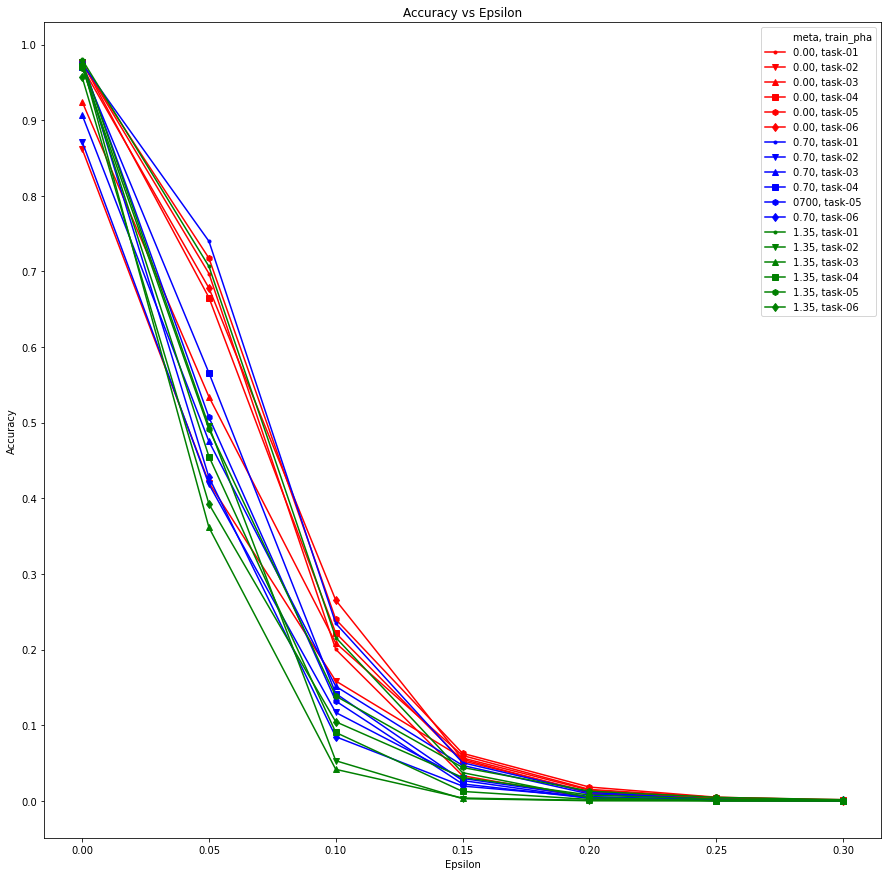

In [8]:
%matplotlib inline
plt.close('all')

plt.figure(figsize=(15,15))
plt.plot([], [], ' ', label='meta, train_pha')
plt.plot(epsilons, accuracies[0], "r.-", label='0.00, task-01')
plt.plot(epsilons, accuracies[1], "rv-", label='0.00, task-02')
plt.plot(epsilons, accuracies[2], "r^-", label='0.00, task-03')
plt.plot(epsilons, accuracies[3], "rs-", label='0.00, task-04')
plt.plot(epsilons, accuracies[4], "rh-", label='0.00, task-05')
plt.plot(epsilons, accuracies[5], "rd-", label='0.00, task-06')
plt.plot(epsilons, accuracies[6], "b.-", label='0.70, task-01')
plt.plot(epsilons, accuracies[7], "bv-", label='0.70, task-02')
plt.plot(epsilons, accuracies[8], "b^-", label='0.70, task-03')
plt.plot(epsilons, accuracies[9], "bs-", label='0.70, task-04')
plt.plot(epsilons, accuracies[10], "bh-", label='0700, task-05')
plt.plot(epsilons, accuracies[11], "bd-", label='0.70, task-06')
plt.plot(epsilons, accuracies[12], "g.-", label='1.35, task-01')
plt.plot(epsilons, accuracies[13], "gv-", label='1.35, task-02')
plt.plot(epsilons, accuracies[14], "g^-", label='1.35, task-03')
plt.plot(epsilons, accuracies[15], "gs-", label='1.35, task-04')
plt.plot(epsilons, accuracies[16], "gh-", label='1.35, task-05')
plt.plot(epsilons, accuracies[17], "gd-", label='1.35, task-06')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()

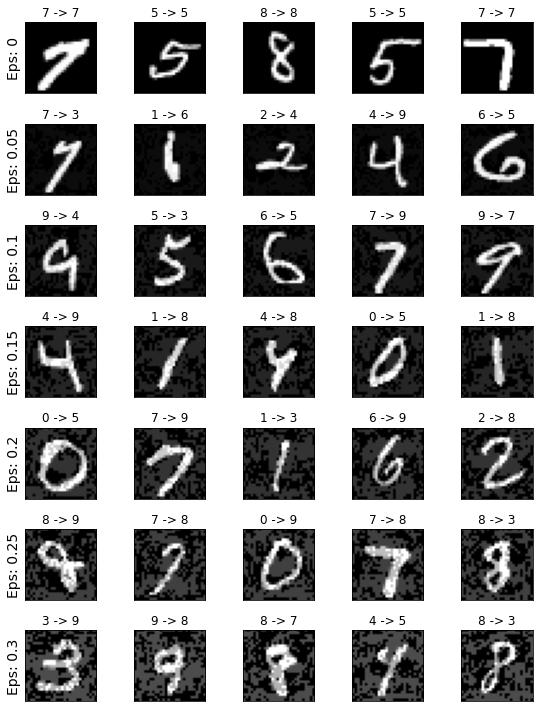

In [29]:
# Plot several examples of adversarial samples at each epsilon
task = 0
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[task][i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[task][0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[task][i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()